<a href="https://colab.research.google.com/github/BianchiLuca28/FHNW-BI-LMS/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Overview
- Predictive model to determine "service_type" for shipments by a B2B company using third-party carriers.
- Dataset includes details like customer pricing, carrier pricing, shipment weights, and delivery locations.
- Objective: Predict service type using machine learning to support operational and strategic business decisions.

## Business Motivation
- **Operational Efficiency**: Optimize logistics and resource allocation.
- **Cost Savings**: Identify cost reduction opportunities.
- **Customer Experience**: Offer tailored services for different customer needs.
- **Strategic Insights**: Analyze profitability and trends across service types to enhance business planning.

## Data Analysis and Preprocessing
- **EDA**: Explored feature distributions, identified outliers, and evaluated class imbalances. This can found in the notebook *notebooks/EDA/eda_notebook.ipynb*.
- **Preprocessing**: Included feature selection, encoding, outlier removal, and margin estimation.

## Modeling Process
- **Handling Imbalanced Data**: Addressed class imbalances with SMOTE for underrepresented service types.
- **"Special" Class Reassessment**: Previously thought to have insufficient samples, further analysis revealed adequate representation in the dataset.
- This allowed inclusion of the "Special" class in the modeling process, with successful handling through SMOTE for training, which was one of the most important classes for the client.
- **Feature Selection** considering only the most important features and the ones that are available during the prediction.

## Model Selection and Evaluation
- **Algorithms**: Evaluated multiple models including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, XGBoost, and LightGBM.
- **Metrics**: Used metrics such as Accuracy, ROC AUC, and detailed classification reports.
- **Final Model**: Random Forest selected for its robust performance, achieving a Test Set Accuracy of 0.9758.

## Conclusion
- The model effectively predicts all service types.
- Provides actionable insights for operational decision-making and improving business efficiency.
- Enables the company to optimize its logistics, reduce costs, and enhance customer satisfaction.
- Having reached such high performance, it is clear that the dataset can indeed undercover some **important pattern** to predict the customer behavior.
- The cost matrix analysis revealed a total cost of 1120, primarily driven by false negatives (1100), reflecting the high impact of missing critical service type predictions. False positives contributed a smaller cost (20), aligning with the business priority of minimizing operational failures over minor inefficiencies. This highlights the importance of optimizing the model to reduce false negatives for greater business value.

# Imports

In [43]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data preprocessing and utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)

# Oversampling
from imblearn.over_sampling import SMOTE

# Statistical tools
from scipy import stats

# Importing dataset

Importing the dataset from the online source in Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change with your location to read the dataset from
folder_path = "/content/drive/MyDrive/__Shared/BI"

In [4]:
df = pd.read_csv(folder_path + "/preprocessed_flattened_dataset.csv")

<ipython-input-4-da48d673589e>:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder_path + "/preprocessed_flattened_dataset.csv")


In [5]:
# # When working locally
# df = pd.read_csv("../../00-Project/datasets/preprocessed_flattened_dataset.csv")

# Preprocessing

In this phase, we treat everything we identified in the EDA phase.

## Removing unavailable columns at the moment of the prediction

These are the columns that aren't avaiable when making the prediction, so they represent something akin to "Target Leakage".

In [6]:
columns_to_exclude = [
    'year_delivery_date', 'month_delivery_date',
    'quarter_delivery_date', 'year_real_delivery_date',
    'month_real_delivery_date', 'quarter_real_delivery_date',
    'final_carrier_price',
    'margin',
    'year_pickup_date', 'month_pickup_date', 'quarter_pickup_date',
    'year_real_pickup_date', 'month_real_pickup_date', 'quarter_real_pickup_date',
    'domain_name_service',
    'domain_name_customer',
    'transport_type', 'shipment_id',
    'name_service',
    "customer_price",
    "expected_carrier_price"
]

In [7]:
# Drop the identified columns to prevent label leakage
df = df.drop(columns=columns_to_exclude, axis=1)

## Handling missing values

To handle the missing values, we approached this problem in the following way:
- For the **service_type**, the rows that are missing the label, we just remove them.
- For the **numerical features**, we replaced them with the median, given the high number of outliers.
- For the **categorical features**, we replaced them with the value *missing*, which we intentionally wanted to introduce as a "new value" to represent the fact that the feature is missing.

In [8]:
# columns with NAs (with more than 0)
df.isna().sum()[df.isna().sum() > 0]

,0
weight,280
shipment_type,280
insurance_type,280
customer_id,280
domain_name,280
lms_plus,280
exworks_id,683441
main_industry_name_customer,222510
industry_sector_name_customer,222510
segmentation_customer,116856


In [9]:
# Drop columns with too many missing values (more than 70% missing)
threshold = len(df) * 0.7
df = df.dropna(axis=1, thresh=threshold)

# Remove rows where 'service_type' is NA
df = df.dropna(subset=['service_type'])

# Fill numeric columns with median and categorical columns with 'missing'
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna('missing')

<ipython-input-9-ba45db47d445>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_cols] = df[categorical_cols].fillna('missing')


## Feature Encoding

As mentioned before, we use the **One-Hot Encoding** for features with less than 10 classes, while we use the **Label Encoding** for the others that have a higher count.

In [10]:
# Split Features and Target
X = df.drop(["service_type"], axis=1)
y = df["service_type"]

In [11]:
# Encoding Strategy for Features
# Split categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Apply Encoding to Categorical Features
# Label Encoding for high-cardinality features, One-Hot Encoding for low-cardinality features
for col in categorical_cols:
    if X[col].nunique() > 10:  # High cardinality threshold (e.g., >10 unique values)
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:
        X = pd.get_dummies(X, columns=[col], drop_first=True)

## Train Test Split, SMOTE, and Scaling

Here we perform the *train_test_split* in a custom way.

In fact, in this phase, we:
1. Split the dataset in train and test (using 80% / 20% division), considering the **stratify** parameter to leave the same distributions of the target variable.
2. Apply SMOTE for the classes that have less than 2000 samples, in the *training dataset* (not in the test dataset), to make at least a bit more balanced the cases, multiplying their proportion by 10 times.
3. Scale the features using a **Standard Scaler**.


*Note*: We didn't remove the outliers, because after testing them, it seemed that the model performed worse, meaning that in this dataset, the outliers, actually had an important meaning.

In [12]:
def calculate_sampling_strategy(y, max_threshold=2000, multiplier=10):
    """
    Calculate the sampling strategy for SMOTE based on the target counts.

    Parameters:
        y (array-like): Target variable for the training set.
        max_threshold (int): Maximum sample count for which SMOTE will be applied.
        multiplier (int): Factor by which the minority classes will be oversampled.

    Returns:
        dict: Sampling strategy for SMOTE.
    """
    sampling_strategy = {}
    unique_classes = pd.Series(y).value_counts()

    for cls, count in unique_classes.items():
        if count < max_threshold:  # Apply SMOTE only to classes with fewer than `max_threshold` samples
            sampling_strategy[cls] = count * multiplier
    return sampling_strategy

In [13]:
def apply_smote(X, y, sampling_strategy, random_state=42):
    """
    Apply SMOTE to balance the classes in the training set.

    Parameters:
        X (pd.DataFrame): Training features.
        y (array-like): Training labels.
        sampling_strategy (dict): Sampling strategy for SMOTE.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: Resampled training features and labels.
    """
    if sampling_strategy:
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
        return smote.fit_resample(X, y)
    return X, y

In [14]:
def scale_features(X_train, X_test, numerical_cols):
    """
    Scale numerical features using StandardScaler.

    Parameters:
        X_train (pd.DataFrame): Training feature set.
        X_test (pd.DataFrame): Test feature set.
        numerical_cols (list): List of numerical feature columns.

    Returns:
        tuple: Scaled training and test feature sets.
    """
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    return X_train_scaled, X_test_scaled

In [15]:
def custom_train_test_split(
    X, y, test_size=0.2, max_threshold=2000, multiplier=10, random_state=42
):
    """
    Perform a stratified train-test split, apply SMOTE for undersampled classes, and scale features.

    Parameters:
        X (pd.DataFrame): Feature dataset.
        y (pd.Series): Target variable.
        test_size (float): Proportion of the dataset to include in the test split.
        max_threshold (int): Maximum sample count for which SMOTE will be applied.
        multiplier (int): Factor by which the minority classes will be oversampled.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: Scaled training and test sets with resampled training labels.
    """
    # Label encoding for the target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )

    # Calculate SMOTE sampling strategy
    sampling_strategy = calculate_sampling_strategy(y_train, max_threshold, multiplier)

    # Apply SMOTE to balance the training set
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train, sampling_strategy, random_state)

    # Scale numerical features
    numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
    X_train_scaled, X_test_scaled = scale_features(X_train_resampled, X_test, numerical_cols)

    # Decode the labels for output consistency
    y_train_resampled_decoded = label_encoder.inverse_transform(y_train_resampled)
    y_test_decoded = label_encoder.inverse_transform(y_test)

    return X_train_scaled, X_test_scaled, y_train_resampled_decoded, y_test_decoded

In [16]:
X_train, X_test, y_train, y_test = custom_train_test_split(
    X, y, test_size=0.2, max_threshold=2000, multiplier=10, random_state=42
)

In [17]:
# Check the shapes
print(f"X_train: {X_train.shape}, y_train: {len(y_train)}")
print(f"X_test: {X_test.shape}, y_test: {len(y_test)}")

X_train: (581857, 56), y_train: 581857
X_test: (142236, 56), y_test: 142236


In [18]:
# Loop through all unique classes in y_train and y_test
for cls in set(y_train).union(set(y_test)):
    train_count = len(y_train[y_train == cls])
    test_count = len(y_test[y_test == cls])
    print(f"{cls} Class in y_train: {train_count}")
    print(f"{cls} Class in y_test: {test_count}")
    print("")

Third_Country Class in y_train: 2670
Third_Country Class in y_test: 67

Sameday Class in y_train: 1300
Sameday Class in y_test: 32

Import Class in y_train: 17001
Import Class in y_test: 4251

Standard Class in y_train: 289897
Standard Class in y_test: 72474

Special Class in y_train: 10380
Special Class in y_test: 260

Express Class in y_train: 260609
Express Class in y_test: 65152



## Feature selection

Using the feature importance from the Random Forest, we include in the dataset, only the 10 features with the highest importance.

Selected Features: ['weight', 'customer_id', 'segmentation_customer', 'sequence_number_customer', 'structure_number_customer', 'postal_code_delivery', 'city_delivery', 'name_country_delivery', 'iso_country_code_delivery', 'EU_delivery', 'postal_code_pickup', 'city_pickup', 'name_country_pickup', 'iso_country_code_pickup', 'name_carrier', 'shipment_type_Parcel', 'continent_delivery_Europe', 'continent_pickup_Europe']


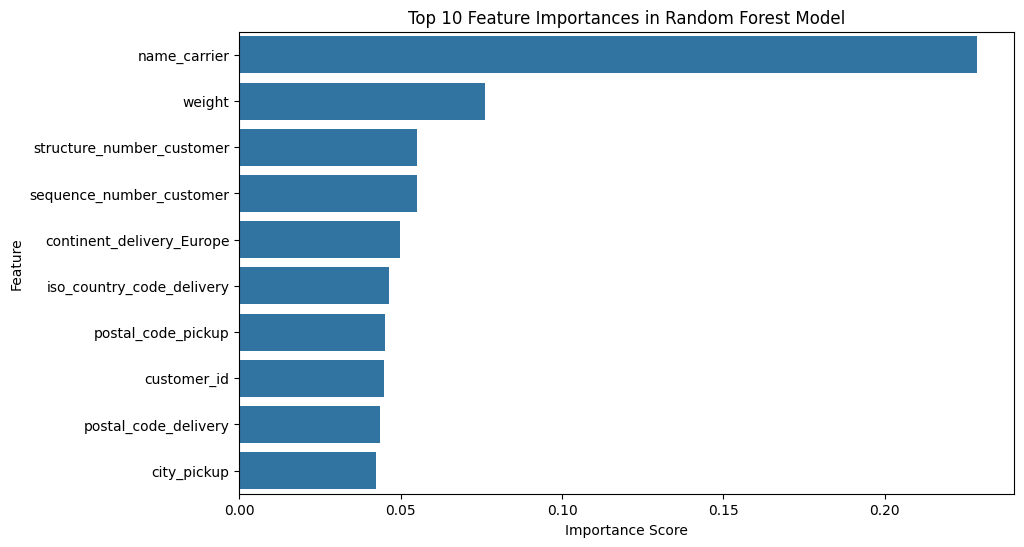

In [19]:
# Random Forest Feature Selection
# Train a RandomForestClassifier to determine feature importance
importance_rf = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduced number of estimators for simplicity
importance_rf.fit(X_train, y_train)

# Get Feature Importances and Select Important Features
feature_importances = pd.Series(importance_rf.feature_importances_, index=X_train.columns)
important_features = feature_importances[feature_importances > 0.01].index.tolist()  # Adjust threshold as needed

# Output the Selected Features
print("Selected Features:", important_features)

# Feature Importance Analysis (Top 10 from Selected Features)
selected_importances = feature_importances[important_features].sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_importances.values, y=selected_importances.index)
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [20]:
# Create Final Dataset with Selected Features
X_selected_train = X_train[important_features]
X_selected_test = X_test[important_features]

# Model Training & Evaluation

Here we finally train and test different models to find the best ones.

We test the following models:
- Logistic Regression.
- Naive Bayes.
- Decision Tree.
- Random Forest.
- XGBoost.
- LightGBM.

Also, for each of the models:
1. We first apply the **K-Fold Cross Validation** (with k=5) to find the best model family.
2. We also train a model again for each of them, in order to compare different metrics for each of them when the model is trained on the whole training dataset.

The metrics we use are:
- Accuracy.
- Cross-Validation Accuracy
- Cross-Validation Standard Deviation.
- ROC-AUC.

In [21]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [22]:
# Prepare training and test data
X_train, X_test = X_selected_train, X_selected_test
y_train, y_test = y_train, y_test

In [23]:
# Label encoding for target
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [24]:
# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Train the model on the whole training dataset this time
    model.fit(X_train, y_train_encoded)

    # Test set predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    class_report = classification_report(y_test_encoded, y_pred, output_dict=True, zero_division=0)
    confusion = confusion_matrix(y_test_encoded, y_pred)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class='ovr')

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Cross-Validation Accuracy": cv_scores.mean(),
        "Cross-Validation Std Dev": cv_scores.std(),
        "Classification Report": class_report,
        "Confusion Matrix": confusion,
        "ROC AUC": roc_auc,
    }

    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"Test Set Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion)
    print("\n" + "=" * 60 + "\n")


Training Logistic Regression...
Logistic Regression Cross-Validation Accuracy: 0.5864 (+/- 0.0010)

Model: Logistic Regression
Test Set Accuracy: 0.5796
ROC AUC: 0.8322
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.47      0.57     65152
           1       0.42      0.69      0.52      4251
           2       0.00      0.56      0.00        32
           3       0.08      0.82      0.15       260
           4       0.71      0.67      0.69     72474
           5       0.00      0.64      0.01        67

    accuracy                           0.58    142236
   macro avg       0.32      0.64      0.32    142236
weighted avg       0.71      0.58      0.63    142236

Confusion Matrix:
[[30532  1861  2806   990 19572  9391]
 [  250  2924   193    39   556   289]
 [    0     3    18     3     7     1]
 [    7     8    25   213     6     1]
 [11127  2162  5864  1272 48714  3335]
 [    8     6     5     0     5    43]]



Training

In [25]:
# Display summary results
results_df = pd.DataFrame({
    model: {
        "Test Accuracy": metrics["Accuracy"],
        "Cross-Val Accuracy": metrics["Cross-Validation Accuracy"],
        "ROC AUC": metrics["ROC AUC"],
    }
    for model, metrics in results.items()
}).T

print("\nSummary of Results:")
print(results_df)


Summary of Results:
                     Test Accuracy  Cross-Val Accuracy   ROC AUC
Logistic Regression       0.579628            0.586448  0.832170
Naive Bayes               0.639247            0.599648  0.841952
Decision Tree             0.916252            0.912898  0.914789
Random Forest             0.937604            0.936579  0.984920
XGBoost                   0.921412            0.922663  0.986530
LightGBM                  0.894492            0.900429  0.924829


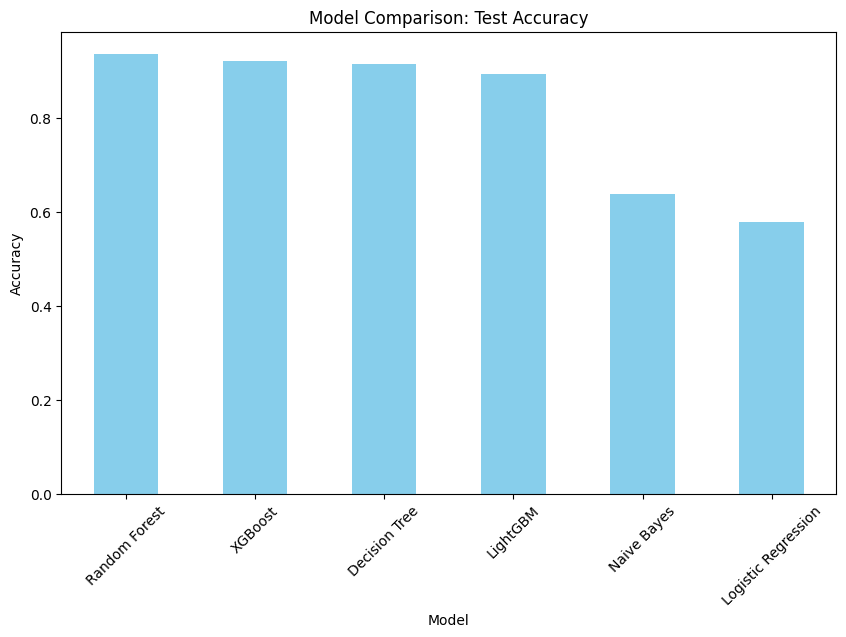

In [26]:
# Plot Test Accuracy for Comparison
plt.figure(figsize=(10, 6))
results_df["Test Accuracy"].sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Model Comparison: Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

# Analysis of Results

### Summary of Business Impact

The Random Forest model provides key insights for optimizing delivery services:
1. **Feature Importance**: The top features driving the predictions indicate which factors most impact the service type, providing insights into areas that can be optimized.
2. **Cost Matrix**: By analyzing the cost associated with false positives and false negatives, the model helps in understanding the financial implications of incorrect predictions. For example, reducing false positives might lower operational costs.
3. **Operational Efficiency**: By accurately predicting the service type, resources can be allocated more effectively, improving overall efficiency.
4. **Customer Targeting**: The insights from feature importance can help target specific customer segments with tailored services, increasing satisfaction and loyalty.

## Train best model

In [27]:
# Train the final Random Forest model
final_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
final_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_rf.predict(X_test)
y_pred_prob = final_rf.predict_proba(X_test)

In [45]:
# Reduce dataset size for tuning
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.1, stratify=y_train, random_state=42)

In [46]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees
    'max_depth': [10, 20, 30],              # Maximum depth of trees
    # 'min_samples_split': [2, 5, 10],              # Minimum samples to split a node
    # 'min_samples_leaf': [1, 2, 4],                # Minimum samples in a leaf
    # 'max_features': ['sqrt', 'log2', None],       # Number of features to consider
    'class_weight': ['balanced', 'balanced_subsample']  # Handle class imbalance
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',     # Evaluation metric
    n_jobs=-1,              # Use all processors
    verbose=2               # Display progress
)

# Fit grid search to the data
grid_search.fit(X_sample, y_sample)

# Output best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


KeyboardInterrupt: 

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'n_estimators': [50, 100, 200, 300],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],              # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],              # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],                # Minimum number of samples in a leaf node
    'max_features': ['sqrt', 'log2', None],       # Features to consider for best split
    'class_weight': ['balanced', 'balanced_subsample']  # Class weighting for imbalance
}

# Use RandomizedSearchCV with fewer folds
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,              # Explore 20 random combinations
    cv=3,                   # Use 3-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)
random_search.fit(X_sample, y_sample)

## Compute metrics of performance

In [29]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
confusion = confusion_matrix(y_test, y_pred)
# Calculate ROC AUC for multiclass
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

In [ ]:
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

## Cost Matrix

For this analysis, we assume the following:
- FN Cost: \$100 (missing a "Special" shipment is highly costly).
- FP Cost: \$10 (mislabeling a regular shipment as "Special" has moderate cost).
- TN/TP Cost: \$0 (correct predictions have no penalty).

The cost matrix emphasizes minimizing **false negatives** as missing a critical service type prediction can lead to significant operational or financial issues, while **false positives** cause minor inefficiencies. This approach aligns with business priorities to ensure service reliability.

In [30]:
# Updated Cost Matrix Analysis
cost_matrix = np.array([[0, 10],
                        [100, 0]])  # Costs: [[TN, FP], [FN, TP]]

# Calculate total cost from confusion matrix
cost = 0

for i in range(len(confusion)):
    for j in range(len(confusion)):
        cost += confusion[i, j] * cost_matrix[min(i, 1), min(j, 1)]  # Map confusion indices to cost matrix
print(f"Total Cost Based on Cost Matrix: {cost}")

Total Cost Based on Cost Matrix: 425630


In [31]:
# Cost Breakdown by Outcome
tn_cost = confusion[0, 0] * cost_matrix[0, 0]
fp_cost = confusion[0, 1] * cost_matrix[0, 1]
fn_cost = confusion[1, 0] * cost_matrix[1, 0]
tp_cost = confusion[1, 1] * cost_matrix[1, 1]

print(f"Cost Breakdown:")
print(f"True Negatives (TN): {tn_cost}")
print(f"False Positives (FP): {fp_cost}")
print(f"False Negatives (FN): {fn_cost}")
print(f"True Positives (TP): {tp_cost}")
print(f"Total Cost: {tn_cost + fp_cost + fn_cost + tp_cost}")

Cost Breakdown:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 200
True Positives (TP): 0
Total Cost: 200


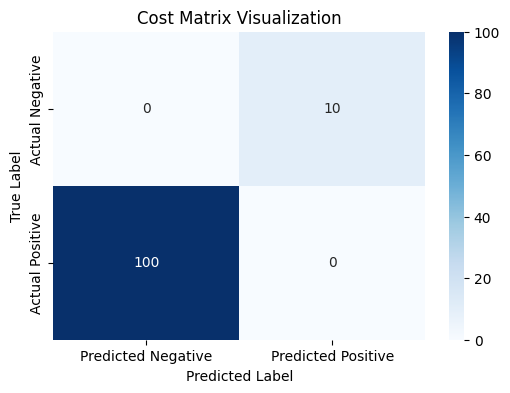

In [32]:
# Visualize the updated cost matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cost_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Cost Matrix Visualization')
plt.show()

## Tree visualization

In this section we can observe the decision rules from a single tree within our random forest model:

- We can view the decision rules with a max depth of 2, as with a depth of 3 we already have problems visualizing it

- We can view the leaf nodes of the tree and the decisions made to get to it

- We will observe common root nodes and class distribution in leaves

- We will analyze the most common paths for each class

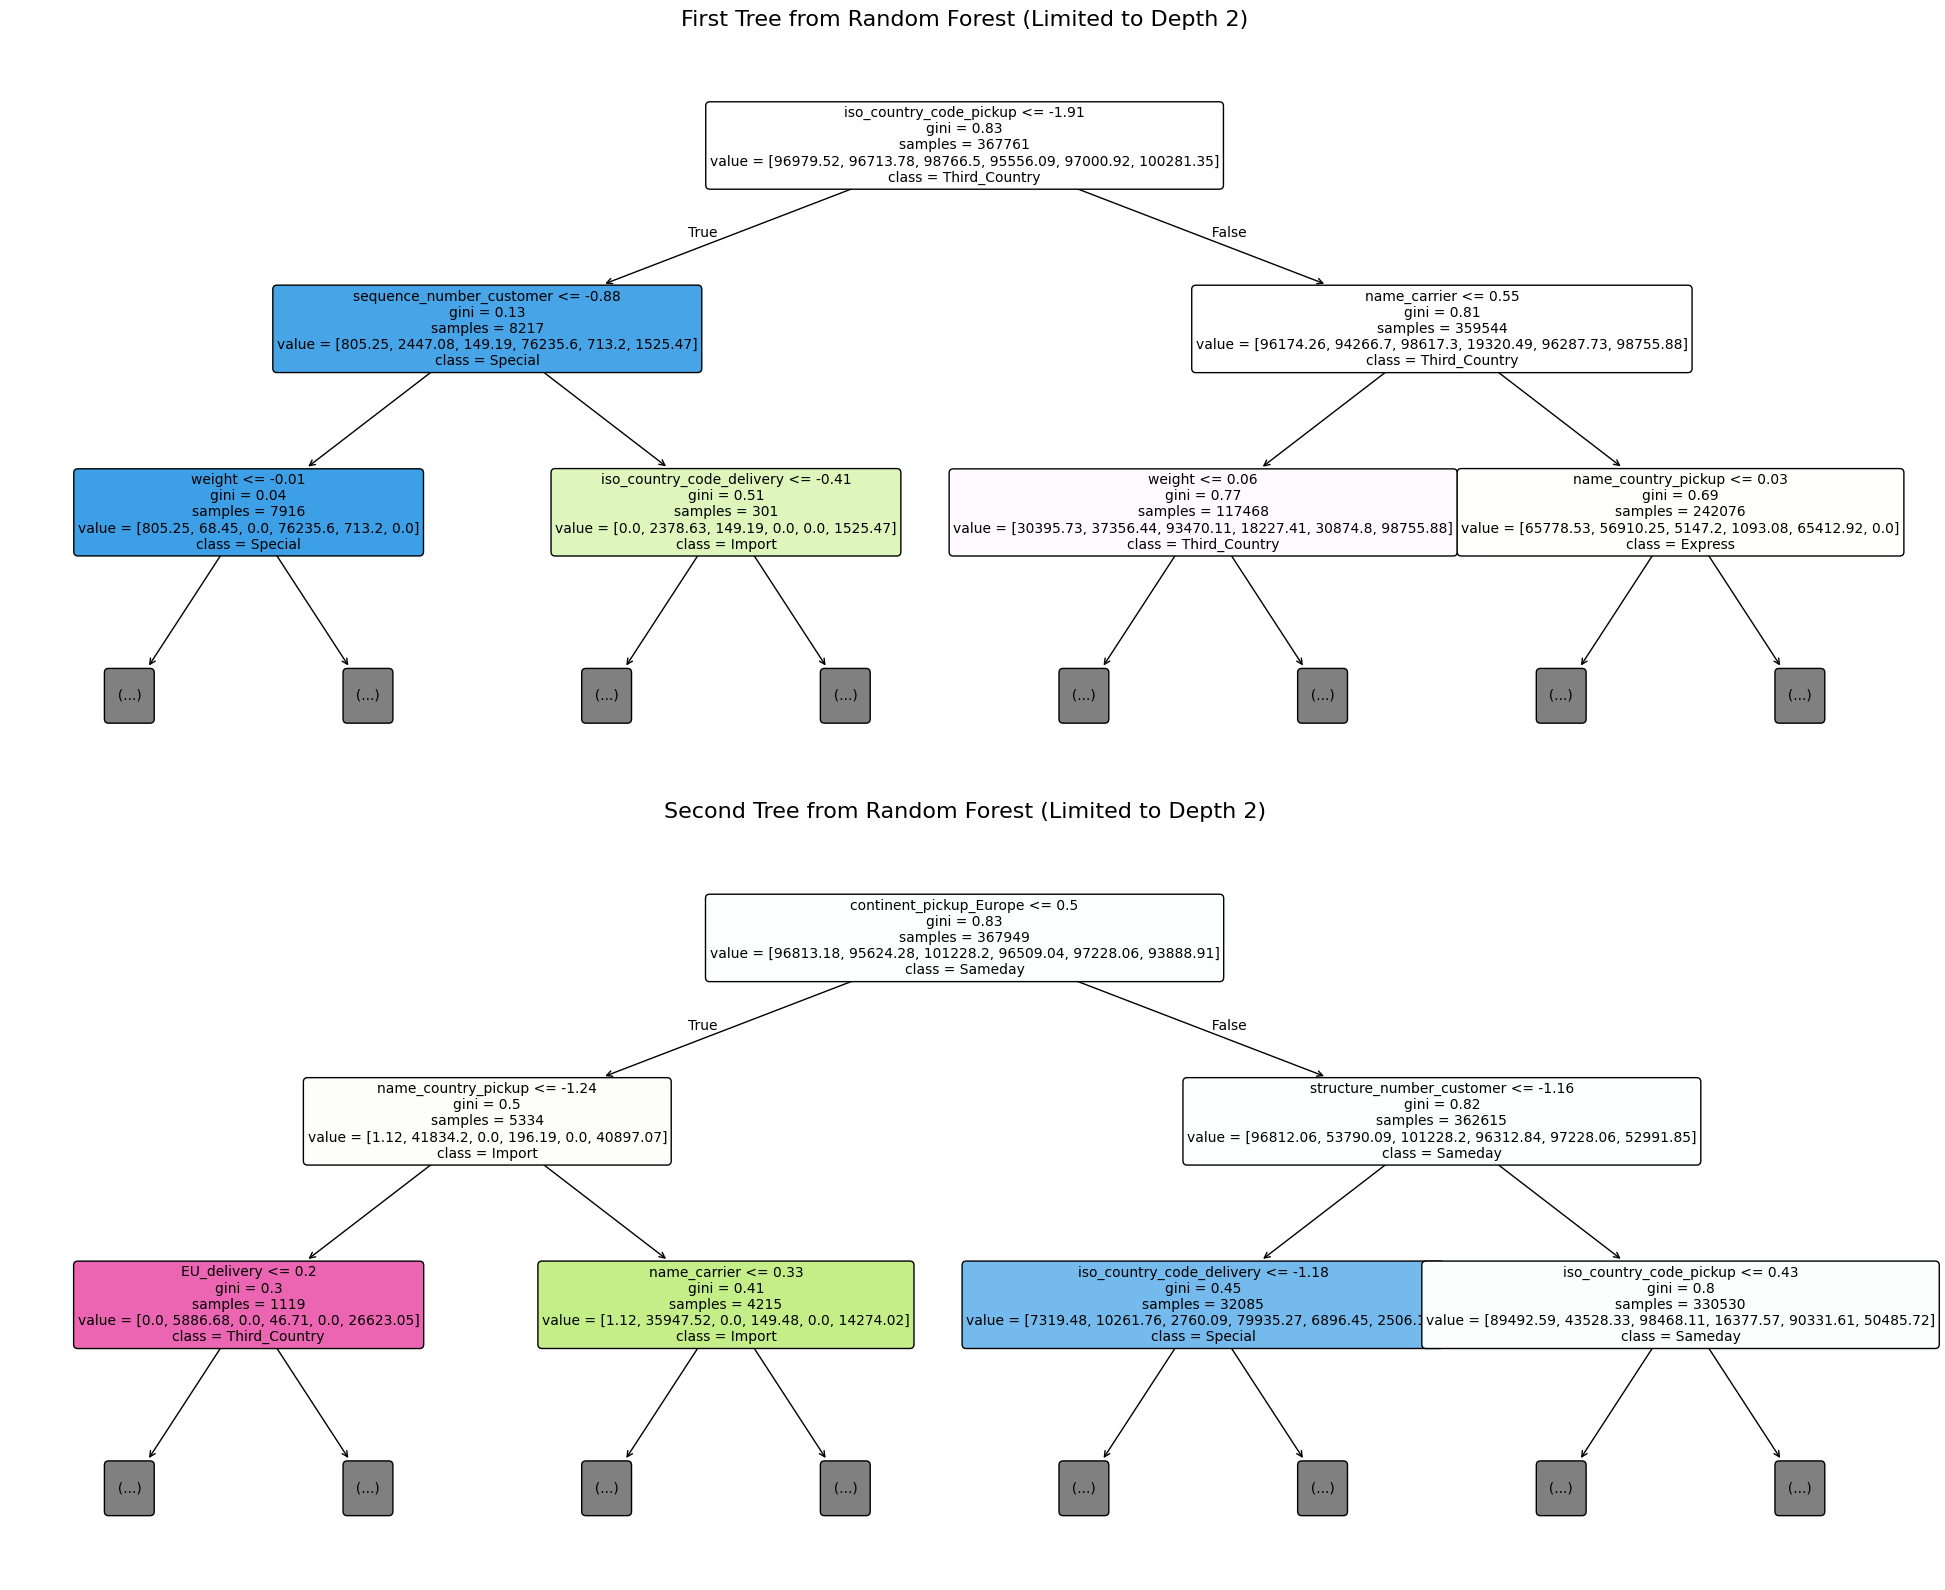

In [33]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Analyze two trees from the random forest
tree1 = final_rf.estimators_[0]  # First tree
tree2 = final_rf.estimators_[1]  # Second tree
tree1_ = tree1.tree_
tree2_ = tree2.tree_

# Visualize both tree structures
plt.figure(figsize=(20, 16))

# Plot first tree
plt.subplot(2, 1, 1)
plot_tree(tree1,
          feature_names=X_train.columns,
          class_names=final_rf.classes_,
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10,
          precision=2)
plt.title("First Tree from Random Forest (Limited to Depth 2)", fontsize=16, pad=20)

# Plot second tree
plt.subplot(2, 1, 2)
plot_tree(tree2,
          feature_names=X_train.columns,
          class_names=final_rf.classes_,
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10,
          precision=2)
plt.title("Second Tree from Random Forest (Limited to Depth 2)", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# Print decision rules for both trees
def print_rules(node, depth, path, tree_, X_train):
    if depth > 2:
        return

    if tree_.children_left[node] != tree_.children_right[node]:  # internal node
        name = X_train.columns[tree_.feature[node]]
        threshold_val = tree_.threshold[node]
        print("Depth", depth)
        print(f"If {name} <= {threshold_val:.2f}:")
        print_rules(tree_.children_left[node], depth + 1, path + [f"{name} <= {threshold_val:.2f}"], tree_, X_train)
        print(f"If {name} > {threshold_val:.2f}:")
        print_rules(tree_.children_right[node], depth + 1, path + [f"{name} > {threshold_val:.2f}"], tree_, X_train)
        print("-" * 30)

print("\nDecision Rules for First Tree:")
print("-" * 50)
print_rules(0, 1, [], tree1_, X_train)

print("\nDecision Rules for Second Tree:")
print("-" * 50)
print_rules(0, 1, [], tree2_, X_train)


In the next cell, we are going to look at 5 sample nodes from each tree, from root to leaf node.

In [34]:
# Function to print leaf nodes for a specific tree
def print_leaves(node, path, tree_, X_train, final_rf, leaves_printed):
    if leaves_printed[0] >= 5:
        return

    if tree_.feature[node] == -2:  # leaf node
        predicted_class = final_rf.classes_[np.argmax(tree_.value[node][0])]
        n_samples = tree_.n_node_samples[node]
        print(f"\nLeaf Node {leaves_printed[0] + 1}:")
        print(f"Decision Path: {' AND '.join(path)}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Number of samples in leaf: {n_samples}")
        print("-" * 50)
        leaves_printed[0] += 1
        return

    name = X_train.columns[tree_.feature[node]]
    threshold = tree_.threshold[node]

    print_leaves(tree_.children_left[node], path + [f"{name} <= {threshold:.2f}"], tree_, X_train, final_rf, leaves_printed)
    if leaves_printed[0] < 5:
        print_leaves(tree_.children_right[node], path + [f"{name} > {threshold:.2f}"], tree_, X_train, final_rf, leaves_printed)

# Print sample leaf nodes for both trees
print("\nSample of 5 Leaf Nodes from First Tree:")
print("=" * 50)
leaves_printed1 = [0]  # Using list to make it mutable
print_leaves(0, [], tree1_, X_train, final_rf, leaves_printed1)

print("\nSample of 5 Leaf Nodes from Second Tree:")
print("=" * 50)
leaves_printed2 = [0]  # Using list to make it mutable
print_leaves(0, [], tree2_, X_train, final_rf, leaves_printed2)

By analyzing them, we have the following insights:
- Geographic Patterns:


  - Primary splits often based on pickup country (name_country_pickup, iso_country_code_pickup)
  - Location codes (postal codes, country codes) heavily influence service type choice

- Customer Characteristics:
  - Customer sequence numbers below -1.18 indicate distinct service preferences
  - Customer structure numbers and IDs influence routing decisions


- Price-Based Rules:
  - Lower customer prices (≤ -0.21) often lead to Standard service
  - Higher expected carrier prices influence routing to Express service
  - Price thresholds vary by geographic region

- Service Selection:
  - Parcel shipments have different rules (seen in first tree)
  - Express is more common with higher customer prices and specific postal code ranges
  - Import class is chosen based on specific country code combinations

In the following cell, we are going to analyze the most common root features and the class distribution in leaves.

In [35]:
n_trees = 100

# Initialize counters for pattern analysis
feature_at_root = {}    # Features used at root node
common_paths = {}       # Common decision paths leading to each class
class_distributions = {} # Distribution of predicted classes per tree
avg_depth = 0          # Average tree depth

# Analyze patterns across specified number of trees
for i in range(n_trees):
    tree = final_rf.estimators_[i]
    tree_ = tree.tree_

    # Count root feature
    root_feature = X_train.columns[tree_.feature[0]]
    feature_at_root[root_feature] = feature_at_root.get(root_feature, 0) + 1

    # Analyze class distribution in leaves
    leaves_mask = tree_.feature == -2
    leaf_classes = [final_rf.classes_[np.argmax(tree_.value[i][0])]
                   for i in range(len(tree_.feature)) if leaves_mask[i]]

    for class_name in leaf_classes:
        class_distributions[class_name] = class_distributions.get(class_name, 0) + 1

    # Calculate tree depth
    avg_depth += tree_.max_depth

avg_depth /= n_trees

# Print analysis results
print(f"\nAnalysis of {n_trees} trees:")
print("\nMost Common Root Features:")
for feature, count in sorted(feature_at_root.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {count} trees ({count/n_trees*100:.1f}%)")

print("\nClass Distribution in Leaves:")
total_leaves = sum(class_distributions.values())
for class_name, count in sorted(class_distributions.items(), key=lambda x: x[1], reverse=True):
    print(f"{class_name}: {count} leaves ({count/total_leaves*100:.1f}%)")

print(f"\nAverage Tree Depth: {avg_depth:.1f}")


Decision Rules for First Tree:
--------------------------------------------------
Depth 1
If iso_country_code_pickup <= -1.91:
Depth 2
If sequence_number_customer <= -0.88:
If sequence_number_customer > -0.88:
------------------------------
If iso_country_code_pickup > -1.91:
Depth 2
If name_carrier <= 0.55:
If name_carrier > 0.55:
------------------------------
------------------------------

Decision Rules for Second Tree:
--------------------------------------------------
Depth 1
If continent_pickup_Europe <= 0.50:
Depth 2
If name_country_pickup <= -1.24:
If name_country_pickup > -1.24:
------------------------------
If continent_pickup_Europe > 0.50:
Depth 2
If structure_number_customer <= -1.16:
If structure_number_customer > -1.16:
------------------------------
------------------------------

Sample of 5 Leaf Nodes from First Tree:

Leaf Node 1:
Decision Path: iso_country_code_pickup <= -1.91 AND sequence_number_customer <= -0.88 AND weight <= -0.01 AND sequence_number_customer

By analyzing them, we have the following insights:
- Location is the primary decision factor, with 62% of trees starting with geographic features

- Weight is a significant factor (15% of root nodes)
- Standard and Express services dominate (96.7% of all leaf nodes)


In the following cell we are going to view the most common paths of 100 trees in relation to the class.

In [36]:
n_trees = 100
max_paths_per_class = 3

# Dictionary to store paths for each class
class_paths = {class_name: [] for class_name in final_rf.classes_}

# Analyze paths in specified number of trees
for i in range(n_trees):
    tree = final_rf.estimators_[i]
    tree_ = tree.tree_

    # Define path extraction for current tree
    def extract_paths(node, path):
        # If leaf node, store the path
        if tree_.feature[node] == -2:
            predicted_class = final_rf.classes_[np.argmax(tree_.value[node][0])]
            class_paths[predicted_class].append((path, tree_.n_node_samples[node]))
            return

        # Get feature name and threshold
        feature = X_train.columns[tree_.feature[node]]
        threshold = tree_.threshold[node]

        # Recurse left
        left_path = path + [(feature, '<=', threshold)]
        extract_paths(tree_.children_left[node], left_path)

        # Recurse right
        right_path = path + [(feature, '>', threshold)]
        extract_paths(tree_.children_right[node], right_path)

    # Extract paths from current tree
    extract_paths(0, [])

# Print analysis results
print(f"\nAnalysis of Common Paths in {n_trees} trees:")
for class_name in final_rf.classes_:
    print(f"\nClass: {class_name}")
    print("=" * 50)

    # Count identical paths
    path_counts = {}
    for path, samples in class_paths[class_name]:
        path_str = ' AND '.join([f"{feat} {op} {val:.2f}" for feat, op, val in path])
        path_counts[path_str] = path_counts.get(path_str, 0) + samples

    # Sort and display most common paths
    sorted_paths = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)
    for path, count in sorted_paths[:max_paths_per_class]:
        print(f"\nDecision Path (samples: {count}):")
        print(path)
        print("-" * 30)


Analysis of Common Paths in 100 trees:

Class: Express

Decision Path (samples: 21784):
structure_number_customer > -1.16 AND name_carrier > 0.55 AND name_country_pickup <= -0.01 AND continent_delivery_Europe > 0.50 AND name_carrier <= 0.62 AND name_country_delivery <= -0.28 AND iso_country_code_pickup > -0.30 AND iso_country_code_pickup <= -0.22 AND iso_country_code_delivery <= -0.43 AND iso_country_code_delivery > -0.47 AND customer_id <= 1.17
------------------------------

Decision Path (samples: 19472):
name_country_delivery > -1.66 AND name_country_pickup <= -0.05 AND name_carrier > 0.55 AND iso_country_code_pickup > -0.30 AND continent_delivery_Europe > 0.50 AND name_carrier <= 0.62 AND name_country_delivery <= -0.28 AND iso_country_code_delivery > -1.14 AND name_country_delivery > -0.44 AND weight <= 0.15 AND iso_country_code_delivery <= -0.27 AND postal_code_pickup <= 1.63 AND shipment_type_Parcel > 0.50 AND iso_country_code_pickup <= -0.22 AND customer_id <= 1.82
-----------

Based on the path analysis, we can view some patterns learned by the model:

- Service Type Decision Rules:

  - Express: Primarily determined by EU locations, moderate prices, and specific carrier combinations
  
  - Import: Triggered by cross-continental shipments, moderate weights, and specific country code patterns
  
  - Sameday: Requires higher customer prices (>0.96), specific city locations, and often no insurance
  
  - Special: Associated with specific delivery codes, customer sequence numbers, and weight thresholds

  - Standard: Characterized by moderate prices, parcel shipments, and specific carrier-location combinations

  - Third_Country: Almost exclusively based on Asian pickup locations and non-EU deliveries

- Common Decision Factors:

  - Geographic features dominate initial decisions (country codes, EU status)
  
  - Price thresholds vary by service type
  
  - Customer characteristics (sequence numbers, segmentation) provide fine-tuning
  
  - Weight plays a role in most service type decisions

## Feature importance

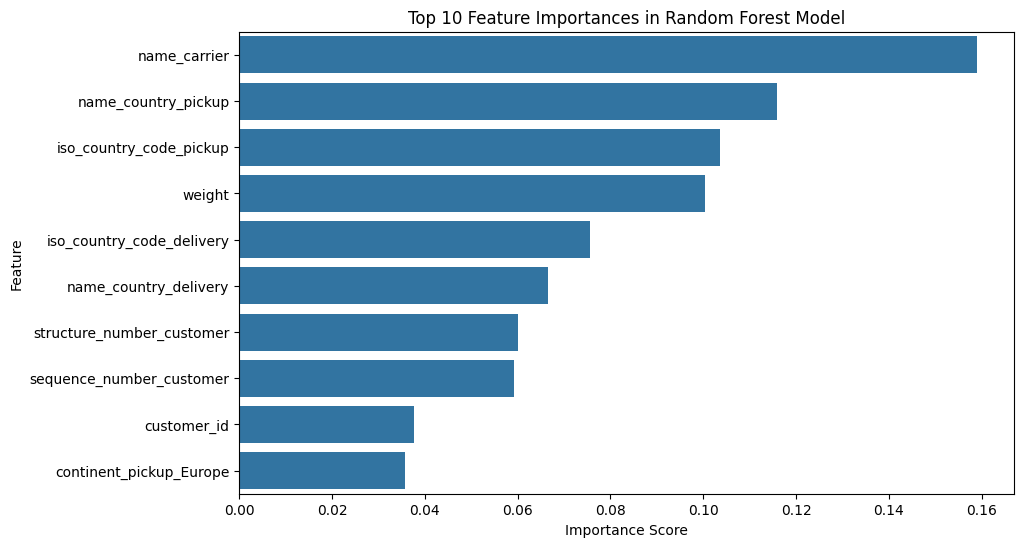

In [37]:
# Feature Importance Analysis
importances = pd.Series(final_rf.feature_importances_, index=X_selected_train.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Business Interpretation

In [38]:
print("\nBusiness Interpretation of Results:")
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:")
for label, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"{label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}")


Business Interpretation of Results:
Test Set Accuracy: 0.9376
ROC AUC: 0.9849
Classification Report:
Express: Precision=0.94, Recall=0.92, F1-score=0.93
Import: Precision=1.00, Recall=1.00, F1-score=1.00
Sameday: Precision=0.95, Recall=0.56, F1-score=0.71
Special: Precision=0.96, Recall=0.92, F1-score=0.94
Standard: Precision=0.93, Recall=0.95, F1-score=0.94
Third_Country: Precision=0.98, Recall=0.82, F1-score=0.89
macro avg: Precision=0.96, Recall=0.86, F1-score=0.90
weighted avg: Precision=0.94, Recall=0.94, F1-score=0.94


For the model analysis, we also have these recommendations:

- Geographic Service Optimization: location is the primary driver with over 62% of root decisions, and ech region has distinct service preferences. Our recommendation would be tailoring service offerings by region and optimizing carrier partnerships accordingly.

- Customer Segmentation Strategy: the customer structure and sequence numbers strongly influence service choice, with different segments showing distinct service preferences. Our recommendation would be developing targeted service packages for different customer segments.